In [ ]:
import numpy as np 
import pandas as pd 



import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))



In [2]:
!pip install librosa numpy pandas tensorflow scikit-learn matplotlib seaborn

In [ ]:
import os
os._exit(00)  

Environment setup complete for LSTM emotion recognition!
TensorFlow version: 2.18.0
Librosa version: 0.11.0
Loading TESS dataset for LSTM model...
Total audio files: 2800
Unique emotions: ['angry', 'disgust', 'fear', 'happy', 'neutral', 'pleasant_surprise', 'sad']

Emotion distribution:
emotion
fear                 400
angry                400
disgust              400
neutral              400
sad                  400
pleasant_surprise    400
happy                400
Name: count, dtype: int64


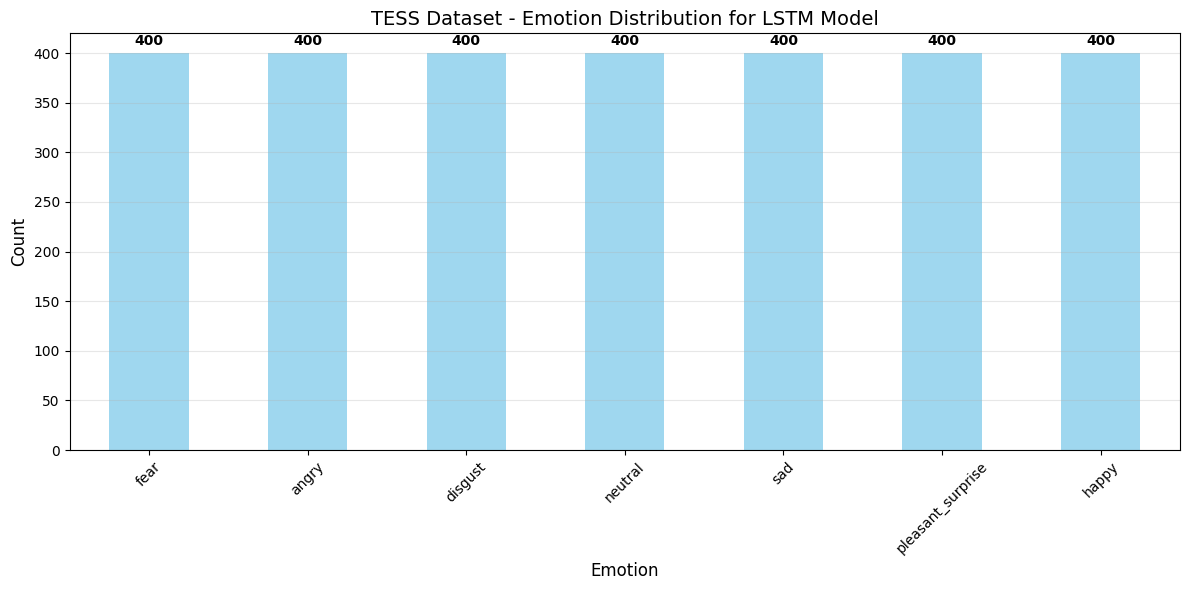


Dataset shape: (2800, 2)

First 5 samples:
                                           file_path emotion
0  /kaggle/input/toronto-emotional-speech-set-tes...    fear
1  /kaggle/input/toronto-emotional-speech-set-tes...    fear
2  /kaggle/input/toronto-emotional-speech-set-tes...    fear
3  /kaggle/input/toronto-emotional-speech-set-tes...    fear
4  /kaggle/input/toronto-emotional-speech-set-tes...    fear


In [ ]:

import os
import numpy as np
import pandas as pd
import librosa
import librosa.display
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
import warnings
warnings.filterwarnings('ignore')

print("Environment setup complete for LSTM emotion recognition!")
print(f"TensorFlow version: {tf.__version__}")
print(f"Librosa version: {librosa.__version__}")


np.random.seed(42)
tf.random.set_seed(42)






def load_tess_for_lstm(data_path='/kaggle/input/toronto-emotional-speech-set-tess/TESS Toronto emotional speech set data'):
    """
    Load TESS dataset specifically for LSTM model training
    """
    audio_files = []
    labels = []
   
    
    emotion_mapping = {
        'angry': 'angry',
        'disgust': 'disgust',
        'fear': 'fear',
        'happy': 'happy',
        'neutral': 'neutral',
        'pleasant_surprised': 'pleasant_surprise',
        'Pleasant_surprise': 'pleasant_surprise',
        'sad': 'sad'
    }
   
    
    for root, dirs, files in os.walk(data_path):
        for file in files:
            if file.endswith('.wav'):
                file_path = os.path.join(root, file)
               
                
                dir_name = os.path.basename(root)
                if '_' in dir_name:
                    emotion = dir_name.split('_', 1)[1]
                    emotion = emotion_mapping.get(emotion.lower(), emotion.lower())
                   
                    audio_files.append(file_path)
                    labels.append(emotion)
   
    return audio_files, labels


print("Loading TESS dataset for LSTM model...")
audio_files, labels = load_tess_for_lstm()

print(f"Total audio files: {len(audio_files)}")
print(f"Unique emotions: {sorted(set(labels))}")


df_lstm = pd.DataFrame({
    'file_path': audio_files,
    'emotion': labels
})


emotion_counts = df_lstm['emotion'].value_counts()
print("\nEmotion distribution:")
print(emotion_counts)


plt.figure(figsize=(12, 6))
emotion_counts.plot(kind='bar', color='skyblue', alpha=0.8)
plt.title('TESS Dataset - Emotion Distribution for LSTM Model', fontsize=14)
plt.xlabel('Emotion', fontsize=12)
plt.ylabel('Count', fontsize=12)
plt.xticks(rotation=45)
plt.grid(axis='y', alpha=0.3)


for i, count in enumerate(emotion_counts.values):
    plt.text(i, count + 5, str(count), ha='center', va='bottom', fontweight='bold')

plt.tight_layout()
plt.show()

print(f"\nDataset shape: {df_lstm.shape}")
print("\nFirst 5 samples:")
print(df_lstm.head()) 

Extracting features for LSTM model...
This may take several minutes...
Processing batch 1: files 1-100 of 2800
Processing batch 2: files 101-200 of 2800
Processing batch 3: files 201-300 of 2800
Processing batch 4: files 301-400 of 2800
Processing batch 5: files 401-500 of 2800
Processing batch 6: files 501-600 of 2800
Processing batch 7: files 601-700 of 2800
Processing batch 8: files 701-800 of 2800
Processing batch 9: files 801-900 of 2800
Processing batch 10: files 901-1000 of 2800
Processing batch 11: files 1001-1100 of 2800
Processing batch 12: files 1101-1200 of 2800
Processing batch 13: files 1201-1300 of 2800
Processing batch 14: files 1301-1400 of 2800
Processing batch 15: files 1401-1500 of 2800
Processing batch 16: files 1501-1600 of 2800
Processing batch 17: files 1601-1700 of 2800
Processing batch 18: files 1701-1800 of 2800
Processing batch 19: files 1801-1900 of 2800
Processing batch 20: files 1901-2000 of 2800
Processing batch 21: files 2001-2100 of 2800
Processing bat

I0000 00:00:1755529011.632603     126 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 13942 MB memory:  -> device: 0, name: Tesla T4, pci bus id: 0000:00:04.0, compute capability: 7.5
I0000 00:00:1755529011.633278     126 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:1 with 13942 MB memory:  -> device: 1, name: Tesla T4, pci bus id: 0000:00:05.0, compute capability: 7.5


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm (LSTM)                     │ (None, 130, 128)       │       145,920 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_1 (LSTM)                   │ (None, 130, 64)        │        49,408 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_2 (LSTM)                   │ (None, 32)             │        12,416 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 64)             │         2,112 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 7)              │           231 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 212,167 (828.78 KB)

 Trainable params: 212,167 (828.78 KB)

 Non-trainable params: 0 (0.00 B)


Training LSTM model...
Epoch 1/100


I0000 00:00:1755529019.992938     174 cuda_dnn.cc:529] Loaded cuDNN version 90300


56/56 ━━━━━━━━━━━━━━━━━━━━ 9s 36ms/step - accuracy: 0.1569 - loss: 1.9408 - val_accuracy: 0.2567 - val_loss: 1.7906 - learning_rate: 0.0010
Epoch 2/100
56/56 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - accuracy: 0.2476 - loss: 1.8093 - val_accuracy: 0.3504 - val_loss: 1.5882 - learning_rate: 0.0010
Epoch 3/100
56/56 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - accuracy: 0.2948 - loss: 1.6337 - val_accuracy: 0.3504 - val_loss: 1.4610 - learning_rate: 0.0010
Epoch 4/100
56/56 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - accuracy: 0.3179 - loss: 1.5396 - val_accuracy: 0.3728 - val_loss: 1.3932 - learning_rate: 0.0010
Epoch 5/100
56/56 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - accuracy: 0.3678 - loss: 1.4652 - val_accuracy: 0.3951 - val_loss: 1.3537 - learning_rate: 0.0010
Epoch 6/100
56/56 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - accuracy: 0.3729 - loss: 1.4424 - val_accuracy: 0.3795 - val_loss: 1.3413 - learning_rate: 0.0010
Epoch 7/100
56/56 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - accuracy: 0.3971 - loss: 1.3938 - val_accuracy

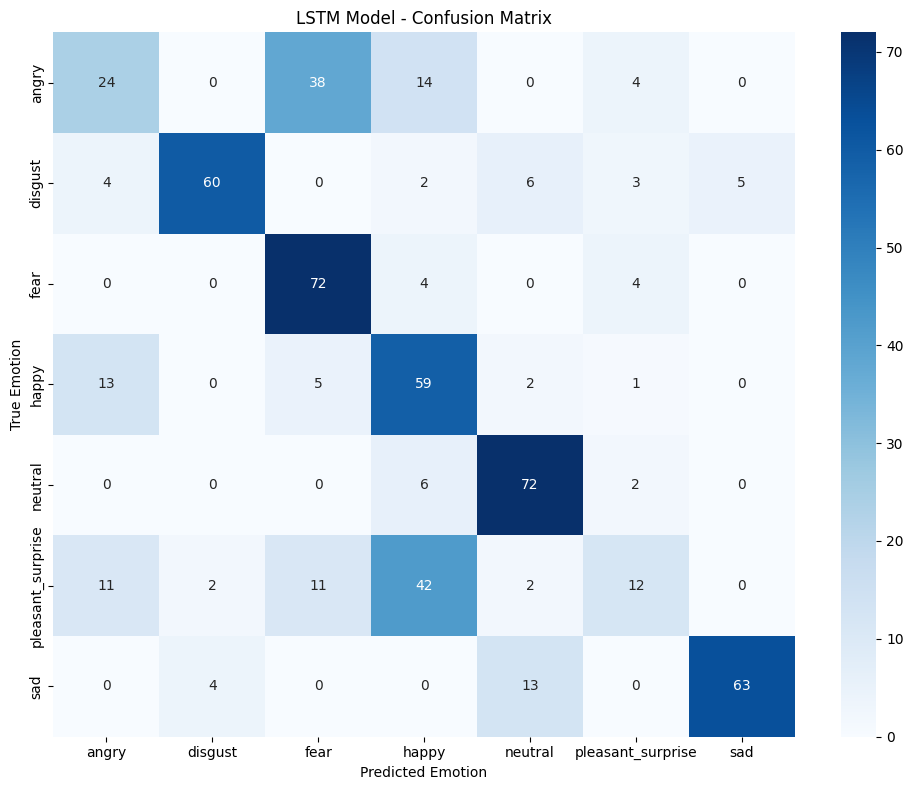

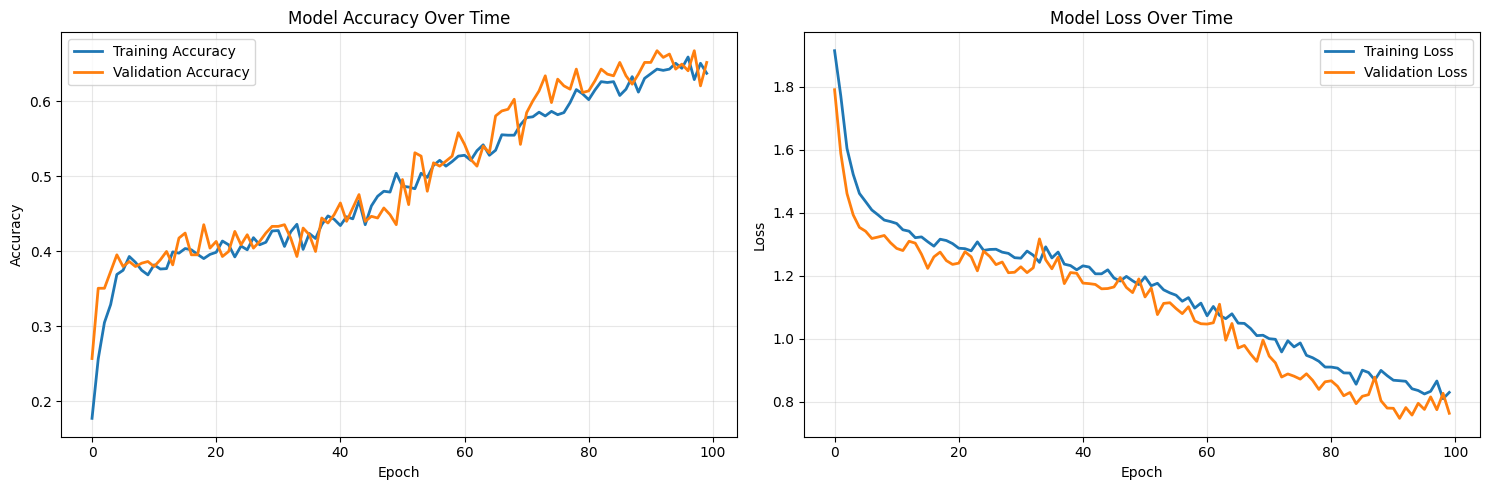

Model saved to /kaggle/working/lstm_emotion_model.h5
Label encoder saved to /kaggle/working/label_encoder.pkl

LSTM model training complete!
Final test accuracy: 0.6643


In [ ]:

def extract_audio_features(file_path, max_length=3.0, sr=22050, n_mfcc=13):
    """
    Extract features from audio file for LSTM model
    Returns sequence of features suitable for LSTM input
    """
    try:
        
        audio, sample_rate = librosa.load(file_path, sr=sr, duration=max_length)
        
        
        target_length = int(sr * max_length)
        if len(audio) < target_length:
            audio = np.pad(audio, (0, target_length - len(audio)), mode='constant')
        else:
            audio = audio[:target_length]
        
        
        mfcc = librosa.feature.mfcc(y=audio, sr=sr, n_mfcc=n_mfcc, hop_length=512)
        
        
        spectral_centroid = librosa.feature.spectral_centroid(y=audio, sr=sr, hop_length=512)[0]
        zero_crossing_rate = librosa.feature.zero_crossing_rate(audio, hop_length=512)[0]
        spectral_rolloff = librosa.feature.spectral_rolloff(y=audio, sr=sr, hop_length=512)[0]
        chroma = librosa.feature.chroma_stft(y=audio, sr=sr, hop_length=512)
        mel_spectrogram = librosa.feature.melspectrogram(y=audio, sr=sr, hop_length=512)
        
        
        features = np.vstack([
            mfcc,
            spectral_centroid.reshape(1, -1),
            zero_crossing_rate.reshape(1, -1),
            spectral_rolloff.reshape(1, -1),
            chroma,
            mel_spectrogram
        ]).T
        
        return features
        
    except Exception as e:
        print(f"Error processing {file_path}: {str(e)}")
        return None


print("Extracting features for LSTM model...")
print("This may take several minutes...")

features_list = []
labels_list = []


batch_size = 100
total_files = len(df_lstm)

for i in range(0, total_files, batch_size):
    batch_end = min(i + batch_size, total_files)
    print(f"Processing batch {i//batch_size + 1}: files {i+1}-{batch_end} of {total_files}")
    
    for idx in range(i, batch_end):
        file_path = df_lstm.iloc[idx]['file_path']
        emotion = df_lstm.iloc[idx]['emotion']
        
        features = extract_audio_features(file_path)
        if features is not None:
            features_list.append(features)
            labels_list.append(emotion)

print(f"Successfully extracted features from {len(features_list)} files")


X = np.array(features_list)
y = np.array(labels_list)

print(f"Feature matrix shape: {X.shape}")
print(f"Labels shape: {y.shape}")


label_encoder = LabelEncoder()
y_encoded = label_encoder.fit_transform(y)
y_categorical = to_categorical(y_encoded)
num_classes = len(label_encoder.classes_)

print(f"Number of classes: {num_classes}")
print(f"Class labels: {label_encoder.classes_}")
print(f"Categorical labels shape: {y_categorical.shape}")


print("\nSplitting data...")
X_train, X_test, y_train, y_test = train_test_split(
    X, y_categorical, test_size=0.2, random_state=42, 
    stratify=y_encoded
)

X_train, X_val, y_train, y_val = train_test_split(
    X_train, y_train, test_size=0.2, random_state=42,
    stratify=np.argmax(y_train, axis=1)
)

print(f"Training set shape: {X_train.shape}")
print(f"Validation set shape: {X_val.shape}")
print(f"Test set shape: {X_test.shape}")


def build_lstm_model(input_shape, num_classes):
    """
    Build LSTM model for emotion recognition
    """
    model = Sequential([
        
        LSTM(128, return_sequences=True, input_shape=input_shape, dropout=0.2),
        
        
        LSTM(64, return_sequences=True, dropout=0.2),
        
        
        LSTM(32, return_sequences=False, dropout=0.2),
        
        
        Dense(64, activation='relu'),
        Dropout(0.3),
        
        Dense(32, activation='relu'),
        Dropout(0.3),
        
        
        Dense(num_classes, activation='softmax')
    ])
    
    
    model.compile(
        optimizer=Adam(learning_rate=0.001),
        loss='categorical_crossentropy',
        metrics=['accuracy']
    )
    
    return model


print("\nBuilding LSTM model...")
model = build_lstm_model((X_train.shape[1], X_train.shape[2]), num_classes)
model.summary()


early_stopping = EarlyStopping(
    monitor='val_loss',
    patience=15,
    restore_best_weights=True,
    verbose=1
)

reduce_lr = ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.5,
    patience=8,
    min_lr=0.00001,
    verbose=1
)


print("\nTraining LSTM model...")
history = model.fit(
    X_train, y_train,
    validation_data=(X_val, y_val),
    epochs=100,
    batch_size=32,
    callbacks=[early_stopping, reduce_lr],
    verbose=1
)


print("\nEvaluating model...")
train_loss, train_accuracy = model.evaluate(X_train, y_train, verbose=0)
val_loss, val_accuracy = model.evaluate(X_val, y_val, verbose=0)
test_loss, test_accuracy = model.evaluate(X_test, y_test, verbose=0)

print(f"Training Accuracy: {train_accuracy:.4f}")
print(f"Validation Accuracy: {val_accuracy:.4f}")
print(f"Test Accuracy: {test_accuracy:.4f}")


y_pred = model.predict(X_test)
y_pred_classes = np.argmax(y_pred, axis=1)
y_test_classes = np.argmax(y_test, axis=1)


print("\nClassification Report:")
print(classification_report(y_test_classes, y_pred_classes, 
                          target_names=label_encoder.classes_))


cm = confusion_matrix(y_test_classes, y_pred_classes)
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
           xticklabels=label_encoder.classes_,
           yticklabels=label_encoder.classes_)
plt.title('LSTM Model - Confusion Matrix')
plt.xlabel('Predicted Emotion')
plt.ylabel('True Emotion')
plt.tight_layout()
plt.show()


def plot_training_history(history):
    """Plot training and validation metrics"""
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))
    
    
    ax1.plot(history.history['accuracy'], label='Training Accuracy', linewidth=2)
    ax1.plot(history.history['val_accuracy'], label='Validation Accuracy', linewidth=2)
    ax1.set_title('Model Accuracy Over Time')
    ax1.set_xlabel('Epoch')
    ax1.set_ylabel('Accuracy')
    ax1.legend()
    ax1.grid(True, alpha=0.3)
    
    
    ax2.plot(history.history['loss'], label='Training Loss', linewidth=2)
    ax2.plot(history.history['val_loss'], label='Validation Loss', linewidth=2)
    ax2.set_title('Model Loss Over Time')
    ax2.set_xlabel('Epoch')
    ax2.set_ylabel('Loss')
    ax2.legend()
    ax2.grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.show()

plot_training_history(history)


model.save('/kaggle/working/lstm_emotion_model.h5')
print("Model saved to /kaggle/working/lstm_emotion_model.h5")


import pickle
with open('/kaggle/working/label_encoder.pkl', 'wb') as f:
    pickle.dump(label_encoder, f)
print("Label encoder saved to /kaggle/working/label_encoder.pkl")


def predict_emotion(audio_path, model, label_encoder):
    """
    Predict emotion for a single audio file
    """
    features = extract_audio_features(audio_path)
    if features is not None:
        features = features.reshape(1, features.shape[0], features.shape[1])
        prediction = model.predict(features, verbose=0)
        predicted_class = np.argmax(prediction)
        confidence = np.max(prediction)
        emotion = label_encoder.classes_[predicted_class]
        return emotion, confidence
    return None, None



print("\nLSTM model training complete!")
print(f"Final test accuracy: {test_accuracy:.4f}")